## Weather Forecasting with Bayesian Network

#### Préparation des données

La préparation des données ainsi que leur discrétisation pour le réseau bayésien a donné lieu à plusieurs recherches afin de comprendre plus précisément le sujet.
- L'humidité est toujours entre 0 et 1 (c'est un %)
- La vitesse du vent est généralement comprise entre 1 et 70 km/h
- La visibilité varie entre moins d'1 km et plus de 40km

Certaines variables (comme la pression ou la loud cover) ne nous paraissaient pas intéressantes. Nous avons fait choix de les retirer.

In [106]:
import numpy as np
import pandas as pd

data = pd.read_csv('./data/weatherHistory.csv')

data = data.dropna()

data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data['Date'] = data['Formatted Date'].dt.date

data_grouped = data.groupby('Date').agg({
    'Summary': lambda x: x.mode()[0],
    'Precip Type': lambda x: x.mode()[0],
    'Temperature (C)': 'median', 
    'Apparent Temperature (C)': 'median',
    'Humidity': 'mean',
    'Wind Speed (km/h)': 'mean',
    'Visibility (km)': 'mean',
}).reset_index()

data_grouped['Temperature (C)'] = data_grouped['Temperature (C)'].apply(lambda x: int(x))

data_grouped['Apparent Temperature (C)'] = data_grouped['Apparent Temperature (C)'].apply(lambda x: int(x))
data_grouped['Humidity_discrete'] = pd.cut(data_grouped['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])
data_grouped['WindSpeed_discrete'] = pd.cut(data_grouped['Wind Speed (km/h)'], bins=5,labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
data_grouped['Visibility_discrete'] = pd.cut(data_grouped['Visibility (km)'],bins=[0, 4, 10, data_grouped['Visibility (km)'].max()],labels=['Poor', 'Medium', 'High'], include_lowest=True)

data_grouped['Humidity_discrete'] = pd.cut(data_grouped['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])

temp_min = data_grouped['Temperature (C)'].min()
temp_max = data_grouped['Temperature (C)'].max()
bins = np.arange(temp_min, temp_max + 2, 2)

data_grouped['Temperature_discrete'] = pd.cut(data_grouped['Temperature (C)'],bins=bins,labels=[f'{x}-{x+2}' for x in bins[:-1]], include_lowest=True)

data_discrete= data_grouped.drop(columns=[
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)'
]).set_index('Date')

data_discrete = data_discrete.rename(columns={
    'Temperature_discrete': 'Temperature',
    'Humidity_discrete': 'Humidity',
    'WindSpeed_discrete': 'WindSpeed',
    'Visibility_discrete': 'Visibility',
})

summary_categories = data_discrete['Summary'].unique()
data_discrete.head()

,Summary,Precip Type,Humidity,WindSpeed,Visibility,Temperature
Date,,,,,,
2005-12-31,Partly Cloudy,rain,High,Medium,Medium,-1-1
2006-01-01,Mostly Cloudy,rain,High,Medium,High,3-5
2006-01-02,Overcast,rain,High,Medium,Medium,3-5
2006-01-03,Overcast,rain,High,Very Low,Medium,1-3
2006-01-04,Overcast,rain,High,Low,Medium,1-3


Nous avons choisi un mapping simple pour permettre de traiter les données catégorielles.

In [107]:
category_mappings = {
    'Visibility': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Humidity': {'Low': 0, 'Medium': 1, 'High': 2},
    'WindSpeed': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'Temperature':{f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Summary': {summary_categories[i] : i for i in range(len(summary_categories))},
    'Precip Type': {'rain': 0, 'snow': 1}
    }

for column, mapping in category_mappings.items():
    data_discrete[column] = data_discrete[column].map(mapping)

print(data_discrete.head())

            Summary  Precip Type Humidity WindSpeed Visibility Temperature
Date                                                                      
2005-12-31        0            0        2         2          1           8
2006-01-01        1            0        2         2          2          10
2006-01-02        2            0        2         2          1          10
2006-01-03        2            0        2         0          1           9
2006-01-04        2            0        2         1          1           9


Chaque variable dépend de sa donnée précédente, et la combinaison de ces données entre en compte dans le calcul de la température.

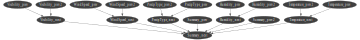

In [108]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

bn_predict = gum.BayesNet('WeatherPrediction')

# previous previous
temp_prev2 = bn_predict.add(gum.LabelizedVariable("Temperature_prev2", "Température avant veille", len(bins)))
hum_prev2 = bn_predict.add(gum.LabelizedVariable("Humidity_prev2", "Humidité avant veille", 3))
wind_prev2 = bn_predict.add(gum.LabelizedVariable("WindSpeed_prev2", "Vitesse avant veille", 5))
visib_prev2 = bn_predict.add(gum.LabelizedVariable("Visibility_prev2", "Visibilité avant veille", 3))
summary_prev2 = bn_predict.add(gum.LabelizedVariable("Summary_prev2", "Résumé avant veille", len(summary_categories)))
precip_prev2 = bn_predict.add(gum.LabelizedVariable("PrecipType_prev2", "Type de précipitation avant veille", 2))

# previous
temp_prev = bn_predict.add(gum.LabelizedVariable("Temperature_prev", "Température du jour précédent", len(bins)))
hum_prev = bn_predict.add(gum.LabelizedVariable("Humidity_prev", "Humidité du jour précédent", 3))
wind_prev = bn_predict.add(gum.LabelizedVariable("WindSpeed_prev", "Vitesse du vent du jour précédent", 5))
visib_prev = bn_predict.add(gum.LabelizedVariable("Visibility_prev", "Visibilité du jour précédent", 3))
summary_prev = bn_predict.add(gum.LabelizedVariable("Summary_prev", "Résumé du jour précédent", len(summary_categories)))
precip_prev = bn_predict.add(gum.LabelizedVariable("PrecipType_prev", "Type de précipitation du jour précédent", 2))

# next
temp_next = bn_predict.add(gum.LabelizedVariable("Temperature_next", "Température du jour suivant", len(bins)))
hum_next = bn_predict.add(gum.LabelizedVariable("Humidity_next", "Humidité du jour suivant", 3))
wind_next = bn_predict.add(gum.LabelizedVariable("WindSpeed_next", "Vitesse du vent du jour suivant", 5))
visib_next = bn_predict.add(gum.LabelizedVariable("Visibility_next", "Visibilité du jour suivant", 3))
summary_next = bn_predict.add(gum.LabelizedVariable("Summary_next", "Résumé du jour suivant", len(summary_categories)))
precip_next = bn_predict.add(gum.LabelizedVariable("PrecipType_next", "Type de précipitation du jour suivant", 2))

bn_predict.addArc(temp_prev, temp_next)
bn_predict.addArc(hum_prev, hum_next)
bn_predict.addArc(wind_prev, wind_next)
bn_predict.addArc(visib_prev, visib_next)
bn_predict.addArc(summary_prev, summary_next)
bn_predict.addArc(precip_prev, precip_next)

bn_predict.addArc(temp_prev2, temp_next)
bn_predict.addArc(hum_prev2, hum_next)
bn_predict.addArc(wind_prev2, wind_next)
bn_predict.addArc(visib_prev2, visib_next)
bn_predict.addArc(summary_prev2, summary_next)
bn_predict.addArc(precip_prev2, precip_next)

bn_predict.addArc(temp_next, summary_next)
bn_predict.addArc(hum_next, summary_next)
bn_predict.addArc(wind_next, summary_next)
bn_predict.addArc(visib_next, summary_next)
bn_predict.addArc(precip_next, summary_next)

gnb.showBN(bn_predict)

In [109]:
data_predict = data_discrete.copy()

data_predict['Temperature_prev'] = data_discrete['Temperature'].shift(1)
data_predict['Humidity_prev'] = data_discrete['Humidity'].shift(1)
data_predict['WindSpeed_prev'] = data_discrete['WindSpeed'].shift(1)
data_predict['Visibility_prev'] = data_discrete['Visibility'].shift(1)
data_predict['Summary_prev'] = data_discrete['Summary'].shift(1).fillna(-1).astype(int)
data_predict['PrecipType_prev'] = data_discrete['Precip Type'].shift(1).fillna(-1).astype(int)

data_predict['Temperature_prev2'] = data_discrete['Temperature'].shift(2)
data_predict['Humidity_prev2'] = data_discrete['Humidity'].shift(2)
data_predict['WindSpeed_prev2'] = data_discrete['WindSpeed'].shift(2)
data_predict['Visibility_prev2'] = data_discrete['Visibility'].shift(2)
data_predict['Summary_prev2'] = data_discrete['Summary'].shift(2).fillna(-1).astype(int)
data_predict['PrecipType_prev2'] = data_discrete['Precip Type'].shift(2).fillna(-1).astype(int)


data_predict = data_predict.rename(columns={
    'Temperature': 'Temperature_next',
    'Humidity': 'Humidity_next',
    'WindSpeed': 'WindSpeed_next',
    'Visibility': 'Visibility_next',
    'Summary': 'Summary_next',
    'Precip Type': 'PrecipType_next',
})

data_predict.dropna(inplace=True)

data_predict.head()

,Summary_next,PrecipType_next,Humidity_next,WindSpeed_next,Visibility_next,Temperature_next,Temperature_prev,Humidity_prev,WindSpeed_prev,Visibility_prev,Summary_prev,PrecipType_prev,Temperature_prev2,Humidity_prev2,WindSpeed_prev2,Visibility_prev2,Summary_prev2,PrecipType_prev2
Date,,,,,,,,,,,,,,,,,,
2006-01-02,2,0,2,2,1,10,10,2,2,2,1,0,8,2,2,1,0,0
2006-01-03,2,0,2,0,1,9,10,2,2,1,2,0,10,2,2,2,1,0
2006-01-04,2,0,2,1,1,9,9,2,0,1,2,0,10,2,2,1,2,0
2006-01-05,2,0,2,1,1,9,9,2,1,1,2,0,9,2,0,1,2,0
2006-01-06,2,0,2,0,1,9,9,2,1,1,2,0,9,2,1,1,2,0


In [110]:
learner = gum.BNLearner(data_predict, bn_predict)

learner.useSmoothingPrior(0.5)
bn_predict_learned = learner.learnParameters(bn_predict)

gnb.showPotential(bn_predict_learned.cpt("Temperature_next"))

In [111]:
category_mappings_predict = {
    'Visibility_prev': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Visibility_prev2': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Visibility_next': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Humidity_prev': {'Low': 0, 'Medium': 1, 'High': 2},
    'Humidity_prev2': {'Low': 0, 'Medium': 1, 'High': 2},
    'Humidity_next': {'Low': 0, 'Medium': 1, 'High': 2},
    'WindSpeed_prev': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'WindSpeed_prev2': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'WindSpeed_next': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'Temperature_prev': {f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Temperature_prev2': {f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Temperature_next': {f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Summary_prev': {summary_categories[i]: i for i in range(len(summary_categories))},
    'Summary_prev2': {summary_categories[i]: i for i in range(len(summary_categories))},
    'Summary_next': {summary_categories[i]: i for i in range(len(summary_categories))},
    'precip_prev': {'rain': 0, 'snow': 1},
    'precip_prev2': {'rain': 0, 'snow': 1},
    'precip_next': {'rain': 0, 'snow': 1}
}

def predict_next_day(date_str):

    date = pd.to_datetime(date_str).date()
    if date not in data_predict.index:
        raise ValueError(f"La date {date} n'est pas présente dans le dataset.")
    
    prev_data = data_predict.loc[date, ['Temperature_prev', 'Humidity_prev', 'WindSpeed_prev', 'Visibility_prev', 'Summary_prev', 'PrecipType_prev',
                                        'Temperature_prev2', 'Humidity_prev2', 'WindSpeed_prev2', 'Visibility_prev2', 'Summary_prev2', 'PrecipType_prev2']]
    
    evidence = {
        "Temperature_prev": int(prev_data['Temperature_prev']),
        "Humidity_prev": int(prev_data['Humidity_prev']),
        "WindSpeed_prev": int(prev_data['WindSpeed_prev']),
        "Visibility_prev": int(prev_data['Visibility_prev']),
        "Summary_prev": int(prev_data['Summary_prev']),
        "PrecipType_prev": int(prev_data['PrecipType_prev']),

        "Temperature_prev2": int(prev_data['Temperature_prev2']),
        "Humidity_prev2": int(prev_data['Humidity_prev2']),
        "WindSpeed_prev2": int(prev_data['WindSpeed_prev2']),
        "Visibility_prev2": int(prev_data['Visibility_prev2']),
        "Summary_prev2": int(prev_data['Summary_prev2']),
        "PrecipType_prev2": int(prev_data['PrecipType_prev2']),
    }
    
    ie = gum.LazyPropagation(bn_predict_learned)
    ie.setEvidence(evidence)
    ie.makeInference()
    
    predictions = {}

    for var in ["Summary_next", "Temperature_next", "Humidity_next", "WindSpeed_next", "Visibility_next", "PrecipType_next"]:
        
        posterior = ie.posterior(var)
        predicted_state = posterior.argmax()[0][0]
        probability = posterior.argmax()[1]

        # Traduction
        inverse_mapping = {
            "Summary_next": {v: k for k, v in category_mappings_predict['Summary_next'].items()},
            "Temperature_next": {v: k for k, v in category_mappings_predict['Temperature_next'].items()},
            "Humidity_next": {v: k for k, v in category_mappings_predict['Humidity_next'].items()},
            "WindSpeed_next": {v: k for k, v in category_mappings_predict['WindSpeed_next'].items()},
            "Visibility_next": {v: k for k, v in category_mappings_predict['Visibility_next'].items()},
            "PrecipType_next": {v: k for k, v in category_mappings_predict['precip_next'].items()},
        }[var]
        predicted_category = inverse_mapping[predicted_state.get(var)]
        predictions[var] = (predicted_category, probability * 100)
    
    return predictions


Nous avons utilisé l'accuracy score car il s'agit d'une métrique avec une interprétation très simple. 
L'accuracy de 50% nous indique que notre code manque de robustesse, certainement à cause de la modélisation simple que nous avons faite dans le réseau bayésien.
(Par exemple, l'humidité n'influe peut-être pas directement sur la température, c'est peut-être le precip type qui influe dessus d'abord.)

In [115]:
from sklearn.metrics import accuracy_score

inverse_mapping = {
            "Summary_next": {v: k for k, v in category_mappings_predict['Summary_next'].items()},
            "Temperature_next": {v: k for k, v in category_mappings_predict['Temperature_next'].items()},
            "Humidity_next": {v: k for k, v in category_mappings_predict['Humidity_next'].items()},
            "WindSpeed_next": {v: k for k, v in category_mappings_predict['WindSpeed_next'].items()},
            "Visibility_next": {v: k for k, v in category_mappings_predict['Visibility_next'].items()},
            "precip_next": {v: k for k, v in category_mappings_predict['precip_next'].items()}
}

def evaluate_summary_accuracy(start_date, end_date):
    true_values = []
    pred_values = []

    for date in pd.date_range(start=start_date, end=end_date):
        date_str = date.strftime('%Y-%m-%d')
        try:
            true_val = data_predict.loc[date.date(), "Summary_next"]
            true_values.append(int(true_val))

            pred_val = predict_next_day(date_str)["Summary_next"][0] 
            pred_values.append(pred_val)
        except ValueError:
            continue
    
    true_values = [inverse_mapping['Summary_next'][value] for value in true_values]

    accuracy = accuracy_score(true_values, pred_values)
    return accuracy

# Évaluation de l'exactitude pour "Summary"
start_date = "2013-09-01"
end_date = "2016-10-10"
summary_accuracy = evaluate_summary_accuracy(start_date, end_date)
print(f"Exactitude pour 'Summary': {summary_accuracy:.2f}")


Exactitude pour 'Summary': 0.49


In [65]:
date_to_predict = "2016-09-18"
predictions = predict_next_day(date_to_predict)

In [114]:
variables_dict = {
    'Temperature_next': 'temperature',
    'Humidity_next': 'humidity',
    'WindSpeed_next': 'wind speed',
    'Visibility_next': 'visibility'
}

forecast_sentence = "On the {}, the weather will be {} with a temperature around {} degrees, {} humidity, {} wind speed and {} visibility. It will probably {}. Good day !".format(
    date_to_predict,
    predictions['Summary_next'][0].lower(),
    predictions['Temperature_next'][0].lower(),
    predictions['Humidity_next'][0].lower(),
    predictions['WindSpeed_next'][0].lower(),
    predictions['Visibility_next'][0].lower(),
    predictions['precip_next'][0]
)

print(forecast_sentence)



KeyError: 'precip_next'